In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.svm import SVC

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# 課題1
## データ分割の仕方を変えていった際の誤り率の平均と分散の変化をみる

In [2]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target
df.shape

(569, 31)

### ホールドアウトの割合を変えていく

In [3]:
results = []

for rate in range(1, 10):
    error_rates = []
    for i in range(100):
        train_X, test_X, train_y, test_y = train_test_split(cancer.data, cancer.target, test_size=rate*0.1)
        model = LogisticRegression()
        model.fit(train_X, train_y)
        error_rates.append(1 - model.score(test_X, test_y))
        
    results.append([rate*0.1, np.mean(error_rates), np.var(error_rates)])

df_results = pd.DataFrame(results, columns=['rate', 'mean', 'variance'])
df_results

,rate,mean,variance
0,0.1,0.047544,0.000624
1,0.2,0.051053,0.000302
2,0.3,0.050760,0.000195
3,0.4,0.049254,0.000154
4,0.5,0.052070,0.000156
5,0.6,0.053801,0.000121
6,0.7,0.053985,0.000087
7,0.8,0.064013,0.000123
8,0.9,0.083762,0.000306


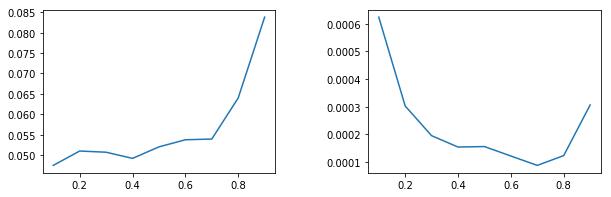

In [4]:
plt.figure(figsize=(10, 3))

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.subplot(1, 2, 1)
plt.plot(df_results['rate'], df_results['mean'])

plt.subplot(1, 2, 2)
plt.plot(df_results['rate'], df_results['variance'])

### CVの分割数を変えていく

In [5]:
results = []

for cv in range(2, 10):
    error_rates = []
    for i in range(100):
        model = LogisticRegression()
        kfold = KFold(n_splits=cv, shuffle=True)
        scores = cross_val_score(model, cancer.data, cancer.target, cv=kfold, scoring="accuracy")
        error_rates.append(np.mean(1 - scores))
    
    results.append([cv, np.mean(error_rates), np.var(error_rates)])
    
df_results = pd.DataFrame(results, columns=['cv', 'mean', 'variance'])
df_results

,cv,mean,variance
0,2,0.052530,0.000025
1,3,0.050276,0.000013
2,4,0.050279,0.000011
3,5,0.049718,0.000009
4,6,0.049527,0.000007
5,7,0.048818,0.000007
6,8,0.048698,0.000007
7,9,0.049413,0.000007


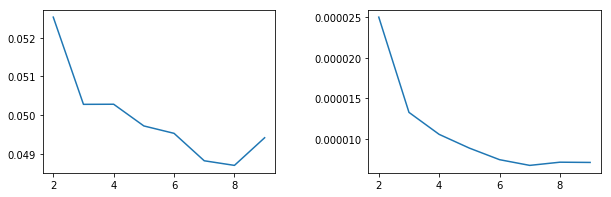

In [6]:
plt.figure(figsize=(10, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(1, 2, 1)
plt.plot(df_results['cv'], df_results['mean'])

plt.subplot(1, 2, 2)
plt.plot(df_results['cv'], df_results['variance'])

# 課題2
## 多項式近似で複数のデータセット間のバイアス、バリアンスを算出する

In [7]:
def f(x):
    e = np.random.normal(loc=0, scale=np.sqrt(0.01), size=len(x))
    return 0.5 + 0.4 * np.sin(2 * np.pi * x) + e

In [8]:
data_x = np.random.rand(11)
data_y = np.array([f(data_x) for i in range(100)])

results = []

for d in [1, 3, 6, 10]:
    predict = []
    for i in range(data_y.shape[0]):
        polynomial_features = PolynomialFeatures(degree=d)
        poly_x = polynomial_features.fit_transform(data_x.reshape(-1, 1))
        model = LinearRegression()
        model.fit(poly_x, data_y[i])
        predict.append(model.predict(poly_x))
    
    predict_mean = np.mean(predict, axis=0)
    bias = (predict_mean - data_y.mean(axis=0)) ** 2
    variance = np.var(predict, axis=0)
    results.append([d, bias.mean(), variance.mean()])

df_results = pd.DataFrame(results, columns=['dim', 'bias', 'variance'])
df_results

,dim,bias,variance
0,1,7.231950e-03,0.001648
1,3,1.404700e-04,0.003502
2,6,4.619954e-05,0.006222
3,10,1.753653e-16,0.010433


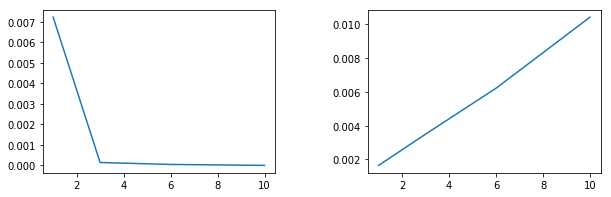

In [9]:
plt.figure(figsize=(10, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.subplot(1, 2, 1)
plt.plot(df_results['dim'], df_results['bias'])

plt.subplot(1, 2, 2)
plt.plot(df_results['dim'], df_results['variance'])

# 課題3
## ROC曲線を描き、AUCを算出

In [10]:
def fit_models(models, x, y):
    for model in models:
        model.fit(x, y)
    return models

def calc_auc(y, predict):
    fp_rate, tp_rate, thresholds = metrics.roc_curve(y, predict)
    print(f'thresholds {thresholds}')
    auc = metrics.auc(fp_rate, tp_rate)
    return fp_rate, tp_rate, auc

In [29]:
train_X, test_X, train_y, test_y = train_test_split(cancer.data, cancer.target, test_size=0.3)

models = [LogisticRegression(), SVC(kernel='linear')]
models = fit_models(models, train_X, train_y)

### ロジスティック回帰とSVM

thresholds [2 1 0]
thresholds [2 1 0]


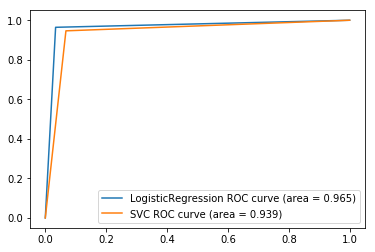

In [30]:
for model in models:
    predict = model.predict(test_X)
    fp_rate, tp_rate, auc = calc_auc(test_y, predict)
    name = model.__class__.__name__
    plt.plot(fp_rate, tp_rate, label=f'{name} ROC curve (area = {round(auc, 3)})')
    plt.legend()

### ロジスティック回帰で予測の閾値を変えてみる

thresholds [2 1 0]
thresholds [2 1 0]
thresholds [2 1 0]


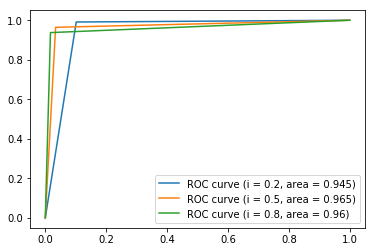

In [31]:
for i in range(2, 10, 3):
    predict = (models[0].predict_proba(test_X)[:, 1] > i * 0.1).astype(int)
    fp_rate, tp_rate, auc = calc_auc(test_y, predict)
    plt.plot(fp_rate, tp_rate, label=f'ROC curve (i = {round(i*0.1, 1)}, area = {round(auc, 3)})')
    plt.legend()

### ロジスティック回帰で確率をそのまま渡す

thresholds [9.99885015e-01 8.35604795e-01 8.26205370e-01 5.58908861e-01
 3.57383688e-01 2.93928129e-01 2.42751395e-01 1.66525021e-01
 1.89750335e-44]


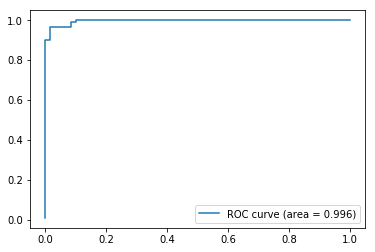

In [32]:
predict = models[0].predict_proba(test_X)[:, 1]
fp_rate, tp_rate, auc = calc_auc(test_y, predict)
plt.plot(fp_rate, tp_rate, label=f'ROC curve (area = {round(auc, 3)})')
plt.legend()